In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from pipelines import *

## Recurrent PINN (RNN-PINN)

In [2]:
class RecurrentPINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256, output_dim=1, num_layers=3):
        super(RecurrentPINN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        # Объединяем x и t
        inputs = torch.cat([x, t], dim=1).unsqueeze(1)  # Добавляем измерение временной последовательности
        out, _ = self.lstm(inputs)
        return self.fc(out[:, -1, :])  # Берем выход последнего временного шага


In [3]:
def compute_physics_loss(model, x_interior, t_interior, equation="heat", a=1.0, b=1.0):
    u_pred = model(x_interior, t_interior)

    # Вычисление производных
    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    if equation == "heat":
        physics_loss = u_t - a * u_xx
    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        physics_loss = u_tt - a * u_xx - b * u_t
    else:
        raise ValueError(f"Unknown equation type: {equation}")

    return torch.mean(physics_loss**2)


In [4]:
def compute_initial_condition_loss(model, x_initial, t_initial, initial_func):
    u_pred_initial = model(x_initial, t_initial)
    u_true_initial = initial_func(x_initial)  # Истинное значение начальных условий
    return torch.mean((u_pred_initial - u_true_initial) ** 2)


In [5]:
def compute_boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, boundary_funcs, a, b):
    u_boundary_pred_0 = model(x_boundary_0, t_boundary)
    u_boundary_pred_pi = model(x_boundary_pi, t_boundary_pi)

    # Производные на границах
    u_x_boundary_0 = torch.autograd.grad(u_boundary_pred_0, x_boundary_0, grad_outputs=torch.ones_like(u_boundary_pred_0), create_graph=True)[0]
    u_x_boundary_pi = torch.autograd.grad(u_boundary_pred_pi, x_boundary_pi, grad_outputs=torch.ones_like(u_boundary_pred_pi), create_graph=True)[0]

    # Истинные значения из boundary_funcs
    true_boundary_0 = boundary_funcs["x0"](t_boundary)
    true_boundary_pi = boundary_funcs["xpi"](t_boundary_pi)

    # Потери
    loss_0 = torch.mean(((u_x_boundary_0 - u_boundary_pred_0) - true_boundary_0) ** 2)
    loss_pi = torch.mean(((u_x_boundary_pi - u_boundary_pred_pi) - true_boundary_pi) ** 2)

    return loss_0 + loss_pi


In [6]:
def loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, equation="wave", a=1.0, b=1.0):
    physics_loss = compute_physics_loss(model, x_interior, t_interior, equation, a, b)
    boundary_loss = compute_boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, boundary_funcs, a, b)
    initial_loss = compute_initial_condition_loss(model, x_initial, t_initial, initial_func)
    return physics_loss + boundary_loss + initial_loss


In [7]:
n_interior = 100
n_boundary = 50

# Внутренние точки
x_interior = torch.tensor(np.random.uniform(0, np.pi, (n_interior, 1)), dtype=torch.float32, requires_grad=True)
t_interior = torch.tensor(np.random.uniform(0, 5, (n_interior, 1)), dtype=torch.float32, requires_grad=True)

# Граничные точки
x_boundary_0 = torch.zeros((n_boundary, 1), dtype=torch.float32, requires_grad=True)
t_boundary = torch.tensor(np.random.uniform(0, 5, (n_boundary, 1)), dtype=torch.float32, requires_grad=True)
x_boundary_pi = torch.full((n_boundary, 1), np.pi, dtype=torch.float32, requires_grad=True)
t_boundary_pi = torch.tensor(np.random.uniform(0, 5, (n_boundary, 1)), dtype=torch.float32, requires_grad=True)

a, b = 1, 1

boundary_funcs = {
    "x0": lambda t: -torch.exp(-a * t) * (torch.cos(b * t) + torch.sin(b * t)),  # u_x(0, t) - u(0, t)
    "xpi": lambda t: torch.exp(-a * t) * (torch.cos(b * t) + torch.sin(b * t))   # u_x(pi, t) - u(pi, t)
}
initial_func = lambda x: torch.cos(x)
x_initial = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32, requires_grad=True).view(-1, 1)  
t_initial = torch.zeros_like(x_initial, requires_grad=True)

In [8]:
model = RecurrentPINN(input_dim=2, hidden_dim=256, output_dim=1, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 10000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Вычисление функции потерь
    loss = loss_function(
        model,
        x_interior,
        t_interior,
        x_boundary_0,
        t_boundary,
        x_boundary_pi,
        t_boundary_pi,
        x_initial,
        t_initial,
        boundary_funcs,
        initial_func,
        equation="heat",
        a=1.0,
        b=1.0
    )

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.735057
Epoch 1000, Loss: 0.000104
Epoch 2000, Loss: 0.000025
Epoch 3000, Loss: 0.000015
Epoch 4000, Loss: 0.000010
Epoch 5000, Loss: 0.000025
Epoch 6000, Loss: 0.000020
Epoch 7000, Loss: 0.000004
Epoch 8000, Loss: 0.000004
Epoch 9000, Loss: 0.000152


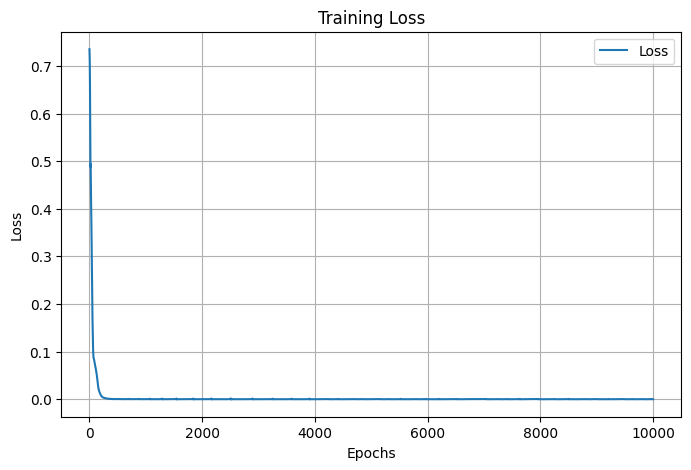

In [10]:
plot_loss(loss_history)

In [13]:
def exact_solution(x, t, a, b):
    return np.exp(-a * t) * np.cos(x + b * t)

In [15]:
# Создадим тестовый набор данных
x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

# Предсказание модели
u_pred = model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)).detach().numpy().reshape(x_mesh.shape)



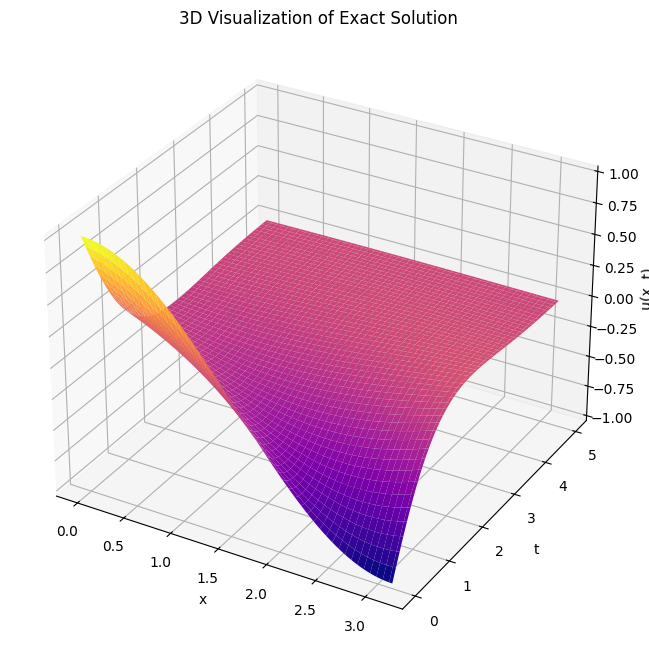

In [16]:
u_exact = exact_solution(x_mesh.numpy(), t_mesh.numpy(), 1, 1)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_exact, cmap="plasma")
ax.set_title("3D Visualization of Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()

In [17]:
hidden_dims = [128, 256, 512]
num_layers = [2, 3, 4]
learning_rates = [0.001, 0.0005]

optimization_results = []

epochs = 5000

In [18]:
from itertools import product

In [19]:
for hidden_dim, num_layer, lr in product(hidden_dims, num_layers, learning_rates):
    print(f"\n🔍 Тестируем: hidden_dim={hidden_dim}, num_layers={num_layer}, lr={lr}")

    # Инициализация модели
    model = RecurrentPINN(input_dim=2, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layer)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = float("inf")
    loss_history = []

    # Обучение модели
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(
            model,
            x_interior,
            t_interior,
            x_boundary_0,
            t_boundary,
            x_boundary_pi,
            t_boundary_pi,
            x_initial,
            t_initial,
            boundary_funcs,
            initial_func,
            equation="heat",
            a=1.0,
            b=1.0
        )
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    # Сохранение результатов
    optimization_results.append({
        "Hidden Dim": hidden_dim,
        "Num Layers": num_layer,
        "Learning Rate": lr,
        "Best Loss": best_loss
    })

    print(f"✅ Завершено для hidden_dim={hidden_dim}, num_layers={num_layer}, lr={lr}. Best Loss: {best_loss:.6e}")


🔍 Тестируем: hidden_dim=128, num_layers=2, lr=0.001
Epoch 0, Loss: 0.740597
Epoch 1000, Loss: 0.000199
Epoch 2000, Loss: 0.000039
Epoch 3000, Loss: 0.000020
Epoch 4000, Loss: 0.000014
✅ Завершено для hidden_dim=128, num_layers=2, lr=0.001. Best Loss: 1.108955e-05

🔍 Тестируем: hidden_dim=128, num_layers=2, lr=0.0005
Epoch 0, Loss: 0.738034
Epoch 1000, Loss: 0.001744
Epoch 2000, Loss: 0.000111
Epoch 3000, Loss: 0.000021
Epoch 4000, Loss: 0.000013
✅ Завершено для hidden_dim=128, num_layers=2, lr=0.0005. Best Loss: 6.682804e-06

🔍 Тестируем: hidden_dim=128, num_layers=3, lr=0.001
Epoch 0, Loss: 0.734316
Epoch 1000, Loss: 0.000294
Epoch 2000, Loss: 0.000030
Epoch 3000, Loss: 0.000012
Epoch 4000, Loss: 0.000006
✅ Завершено для hidden_dim=128, num_layers=3, lr=0.001. Best Loss: 3.605800e-06

🔍 Тестируем: hidden_dim=128, num_layers=3, lr=0.0005
Epoch 0, Loss: 0.743214
Epoch 1000, Loss: 0.001016
Epoch 2000, Loss: 0.000157
Epoch 3000, Loss: 0.000049
Epoch 4000, Loss: 0.000021
✅ Завершено для h

In [ ]:
import pandas as pd

# Преобразование результатов в DataFrame
optimization_results_df = pd.DataFrame(optimization_results)

# Сохранение результатов в CSV
optimization_results_df.to_csv("optimization_rnn_pinn.csv", index=False)
print("\n📊 Результаты оптимизации сохранены в 'optimization_rnn_pinn.csv'.")

# Вывод лучших параметров
best_params = optimization_results_df.nsmallest(1, "Best Loss")
print("\n🏆 Лучшие параметры для Recurrent PINN:")
print(best_params)


📊 Результаты оптимизации сохранены в 'optimization_rnn_pinn.csv'.

🏆 Лучшие параметры для Recurrent PINN:
   Hidden Dim  Num Layers  Learning Rate  Best Loss
2         128           3          0.001   0.000004


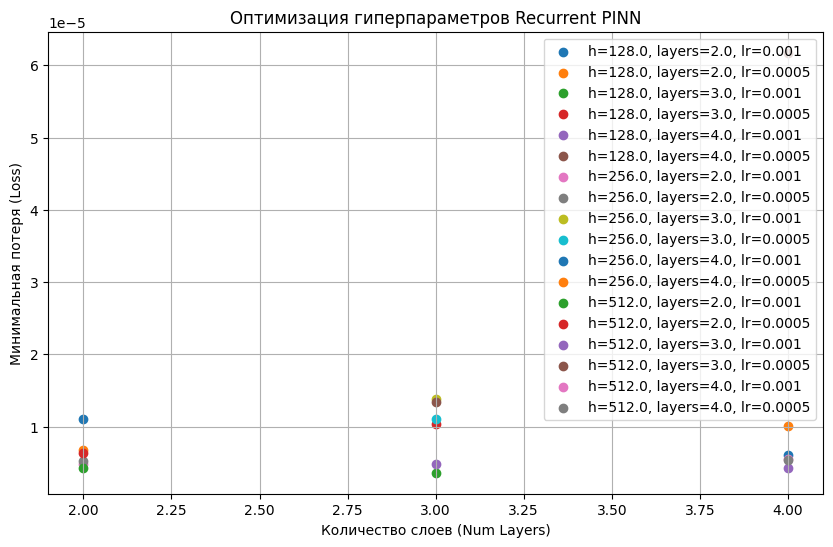

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for _, row in optimization_results_df.iterrows():
    label = f"h={row['Hidden Dim']}, layers={row['Num Layers']}, lr={row['Learning Rate']}"
    plt.scatter(row["Num Layers"], row["Best Loss"], label=label)

plt.xlabel("Количество слоев (Num Layers)")
plt.ylabel("Минимальная потеря (Loss)")
plt.title("Оптимизация гиперпараметров Recurrent PINN")
plt.legend()
plt.grid(True)
plt.show()


Возьмем модель с лучшими параметрами

In [9]:
top_model = RecurrentPINN(2, 256, 1, 3)
optimizer = optim.Adam(top_model.parameters(), lr=0.001)

In [10]:
epochs = 10000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Вычисление функции потерь
    loss = loss_function(
        top_model,
        x_interior,
        t_interior,
        x_boundary_0,
        t_boundary,
        x_boundary_pi,
        t_boundary_pi,
        x_initial,
        t_initial,
        boundary_funcs,
        initial_func,
        equation="heat",
        a=1.0,
        b=1.0
    )

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.858323
Epoch 1000, Loss: 0.000094
Epoch 2000, Loss: 0.000053
Epoch 3000, Loss: 0.000009
Epoch 4000, Loss: 0.000005
Epoch 5000, Loss: 0.000013
Epoch 6000, Loss: 0.000003
Epoch 7000, Loss: 0.000317
Epoch 8000, Loss: 0.000002
Epoch 9000, Loss: 0.000002


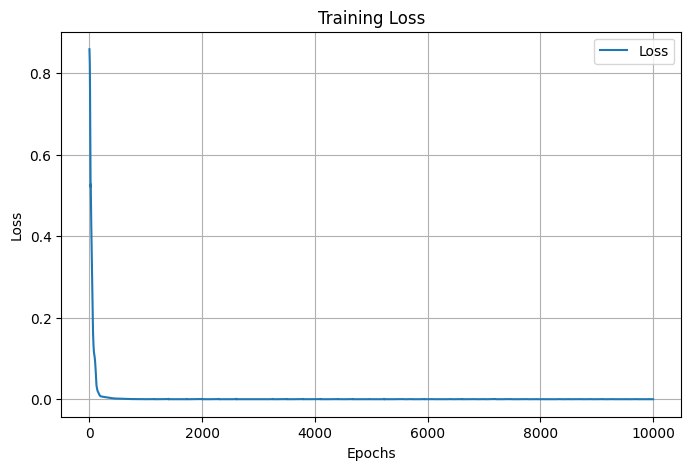

In [11]:
plot_loss(loss_history)

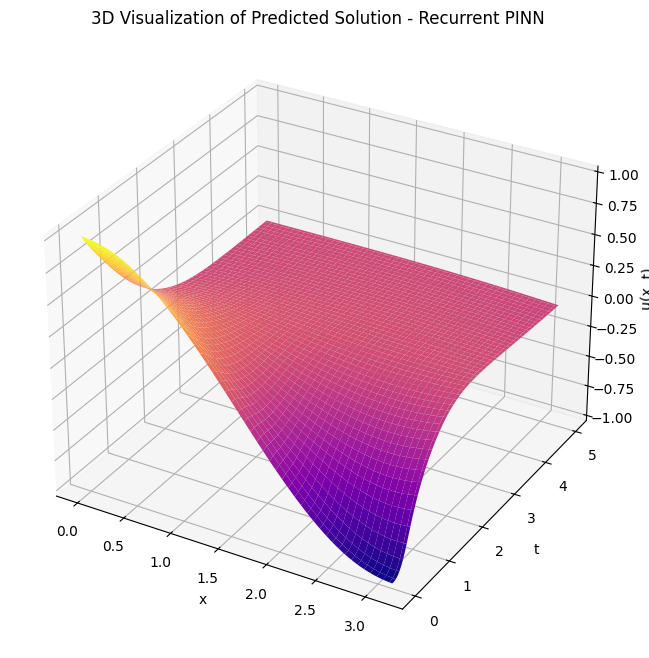

In [16]:
# Предсказание модели
u_pred = top_model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)).detach().numpy().reshape(x_mesh.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_pred, cmap="plasma")
ax.set_title("3D Visualization of Predicted Solution - Recurrent PINN")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()


In [17]:
n_test_interior = 1000  

# Генерация случайных точек внутри области
x_test_interior = torch.tensor(np.random.uniform(0, np.pi, (n_test_interior, 1)), dtype=torch.float32, requires_grad=True)
t_test_interior = torch.tensor(np.random.uniform(0, 5, (n_test_interior, 1)), dtype=torch.float32, requires_grad=True)

n_test_boundary = 100  

# Граничные точки
x_test_boundary_0 = torch.zeros((n_test_boundary, 1), dtype=torch.float32)  # x=0
x_test_boundary_pi = torch.full((n_test_boundary, 1), np.pi, dtype=torch.float32)  # x=π
t_test_boundary = torch.tensor(np.linspace(0, 5, n_test_boundary), dtype=torch.float32).view(-1, 1)

n_test_initial = 100  

# Начальные точки
x_test_initial = torch.tensor(np.linspace(0, np.pi, n_test_initial), dtype=torch.float32).view(-1, 1)
t_test_initial = torch.zeros_like(x_test_initial)  # t=0 для всех



In [18]:
physics_loss = compute_physics_loss(top_model, x_test_interior, t_test_interior, equation="heat", a=1.0, b=1.0)
print(f"🔹 Средняя физическая ошибка (Physics Loss): {physics_loss.item():.6e}")


🔹 Средняя физическая ошибка (Physics Loss): 1.129674e-02


In [19]:
u_boundary_0 = top_model(x_test_boundary_0, t_test_boundary).detach().numpy()
u_boundary_pi = top_model(x_test_boundary_pi, t_test_boundary).detach().numpy()

boundary_error_0 = np.mean((u_boundary_0 - boundary_funcs["x0"](t_test_boundary).numpy())**2)
boundary_error_pi = np.mean((u_boundary_pi - boundary_funcs["xpi"](t_test_boundary).numpy())**2)

print(f"🔹 Ошибка на границе x=0: {boundary_error_0:.6e}")
print(f"🔹 Ошибка на границе x=π: {boundary_error_pi:.6e}")


🔹 Ошибка на границе x=0: 5.575832e-01
🔹 Ошибка на границе x=π: 5.224479e-01


In [20]:
u_initial = top_model(x_test_initial, t_test_initial).detach().numpy()
initial_error = np.mean((u_initial - initial_func(x_test_initial).numpy())**2)

print(f"🔹 Ошибка начальных условий: {initial_error:.6e}")


🔹 Ошибка начальных условий: 3.226895e-07


In [21]:
# Прогоняем тестовые данные через модель
u_pred_interior = top_model(x_test_interior, t_test_interior).detach().numpy()
u_pred_boundary_0 = top_model(x_test_boundary_0, t_test_boundary).detach().numpy()
u_pred_boundary_pi = top_model(x_test_boundary_pi, t_test_boundary).detach().numpy()
u_pred_initial = top_model(x_test_initial, t_test_initial).detach().numpy()


In [22]:
def analytical_solution(x, t, a=1.0, b=1.0):
    return np.exp(-a * t) * np.cos(x + b*t)  # Пример аналитического решения

u_analytic = analytical_solution(x_test_interior.detach().numpy(), t_test_interior.detach().numpy())

# Среднеквадратичная ошибка предсказаний модели относительно аналитического решения
mse_error = np.mean((u_pred_interior - u_analytic) ** 2)
print(f"🔹 Среднеквадратичная ошибка (MSE) относительно аналитического решения: {mse_error:.6e}")


🔹 Среднеквадратичная ошибка (MSE) относительно аналитического решения: 1.755615e-02


In [26]:
grid_size = 100  # Количество точек по x и t

# Создаём равномерную сетку (grid) вместо случайных точек
x_test = torch.tensor(np.linspace(0, np.pi, grid_size), dtype=torch.float32)
t_test = torch.tensor(np.linspace(0, 5, grid_size), dtype=torch.float32)

# Создаём двумерную сетку (meshgrid)
x_test_mesh, t_test_mesh = torch.meshgrid(x_test, t_test, indexing="ij")

# Преобразуем сетку в 1D для передачи в модель
x_test_flat = x_test_mesh.reshape(-1, 1)
t_test_flat = t_test_mesh.reshape(-1, 1)

In [27]:
u_pred = top_model(x_test_flat, t_test_flat).detach().numpy()

# Преобразуем в 2D-формат для визуализации
u_pred_reshaped = u_pred.reshape(grid_size, grid_size)

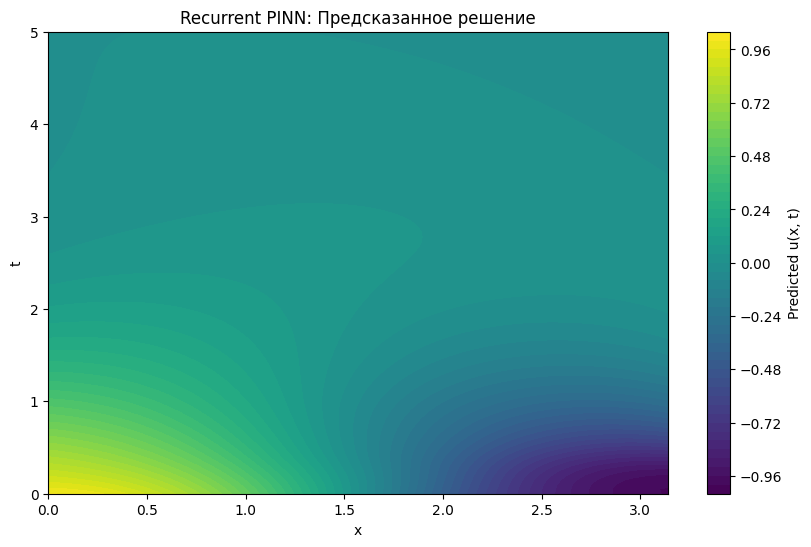

In [28]:
plt.figure(figsize=(10, 6))
plt.contourf(
    x_test_mesh.numpy(), t_test_mesh.numpy(), u_pred_reshaped,
    levels=50, cmap="viridis"
)
plt.colorbar(label="Predicted u(x, t)")
plt.title("Recurrent PINN: Предсказанное решение")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

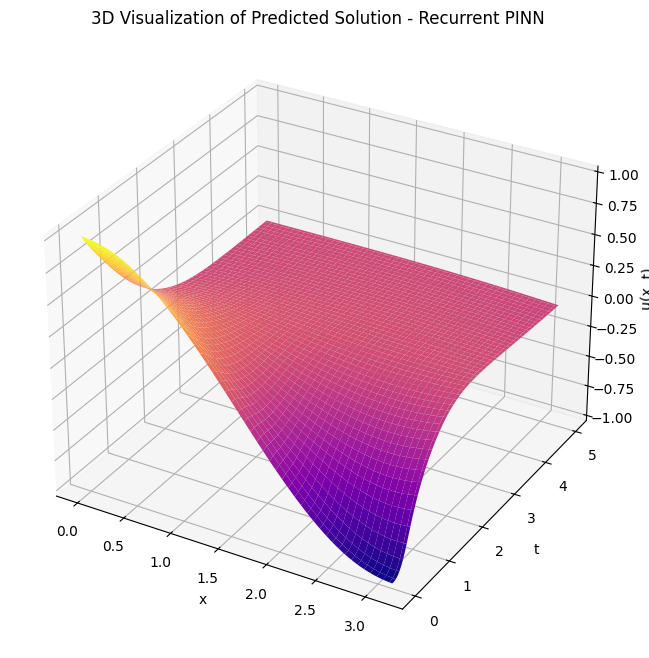

In [32]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x_test_mesh.numpy(), t_test_mesh.numpy(), u_pred_reshaped,
    cmap="plasma"
)

ax.set_title("3D Visualization of Predicted Solution - Recurrent PINN")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()


## Transformer-PINNs

In [33]:
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=4, num_layers=3, output_dim=1):
        super(TransformerPINN, self).__init__()

        # Линейное отображение входных данных в эмбеддинги
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Определение трансформерных слоев
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Финальный выходной слой
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x, t):
        # Объединяем входные параметры x и t
        inputs = torch.cat([x, t], dim=1).unsqueeze(1)  # [batch, seq_len=1, features]

        # Применяем эмбеддинг и передаем через трансформер
        x = self.embedding(inputs)
        x = self.transformer_encoder(x)

        # Выход модели
        x = self.fc(x.squeeze(1))  # Убираем фиктивное измерение seq_len
        return x

In [34]:
# Инициализация модели
model = TransformerPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
epochs = 10000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    loss = loss_function(
        model,
        x_interior,
        t_interior,
        x_boundary_0,
        t_boundary,
        x_boundary_pi,
        t_boundary_pi,
        x_initial,
        t_initial,
        boundary_funcs,
        initial_func,
        equation="heat",
        a=1.0,
        b=1.0
    )

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Обучение завершено!")


/Users/dmitry/Desktop/project/pinn_venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0, Loss: 3.819106
Epoch 1000, Loss: 0.003341
Epoch 2000, Loss: 0.001919
Epoch 3000, Loss: 0.000972
Epoch 4000, Loss: 0.000677
Epoch 5000, Loss: 0.000621
Epoch 6000, Loss: 0.000656


KeyboardInterrupt: 

In [ ]:
plot_loss(loss_history)

In [ ]:
u_pred = model(x_test_flat, t_test_flat).detach().numpy()
u_pred_reshaped = u_pred.reshape(grid_size, grid_size)

# Визуализация
plt.figure(figsize=(10, 6))
plt.contourf(
    x_test_mesh.numpy(), t_test_mesh.numpy(), u_pred_reshaped,
    levels=50, cmap="viridis"
)
plt.colorbar(label="Predicted u(x, t)")
plt.title("Transformer-PINN: Предсказанное решение")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [35]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x, t):
        attn_output, _ = self.multihead_attn(x, t, t)
        return attn_output


In [36]:
class TransformerPINN(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=4, num_layers=3, output_dim=1):
        super(TransformerPINN, self).__init__()

        self.embedding_x = nn.Linear(1, embed_dim)
        self.embedding_t = nn.Linear(1, embed_dim)
        self.cross_attn = CrossAttention(embed_dim, num_heads)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x, t):
        x = self.embedding_x(x).unsqueeze(1)  # [batch, 1, embed_dim]
        t = self.embedding_t(t).unsqueeze(1)  # [batch, 1, embed_dim]

        x = self.cross_attn(x, t)  # Cross-Attention
        x = self.transformer_encoder(x)

        x = self.fc(x.squeeze(1))
        return x


In [38]:
from itertools import product
import torch.optim as optim

embed_dims = [64, 128, 256]
num_heads = [2, 4, 8]
num_layers = [2, 3, 4]
learning_rates = [0.001, 0.0005]
optimization_results = []

best_loss = float("inf")
best_params = None

for embed_dim, num_head, num_layer, lr in product(embed_dims, num_heads, num_layers, learning_rates):
    model = TransformerPINN(embed_dim=embed_dim, num_heads=num_head, num_layers=num_layer)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"\n🔍 Тестируем: embed_dim={embed_dim}, num_head={num_head}, num_layers={num_layer}, lr={lr}")

    for epoch in range(5000):
        optimizer.zero_grad()
        loss = loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = (embed_dim, num_head, num_layer, lr)
            
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    optimization_results.append({
        "Embed Dim": embed_dim,
        "Num Head" : num_head,
        "Num Layers": num_layer,
        "Learning Rate": lr,
        "Best Loss": best_loss
    })
    print(f"✅ Завершено для embed_dim={embed_dim}, num_head={num_head}, num_layers={num_layer}, lr={lr}. Best Loss: {best_loss:.6e}")

print(f"🏆 Лучшие параметры: {best_params}, Loss: {best_loss:.6e}")


/Users/dmitry/Desktop/project/pinn_venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



🔍 Тестируем: embed_dim=64, num_head=2, num_layers=2, lr=0.001
Epoch 0, Loss: 2.465008
Epoch 1000, Loss: 0.758913
Epoch 2000, Loss: 0.748241
Epoch 3000, Loss: 0.745526
Epoch 4000, Loss: 0.750455
✅ Завершено для embed_dim=64, num_head=2, num_layers=2, lr=0.001. Best Loss: 7.255008e-01

🔍 Тестируем: embed_dim=64, num_head=2, num_layers=2, lr=0.0005
Epoch 0, Loss: 1.075700
Epoch 1000, Loss: 0.757861
Epoch 2000, Loss: 0.742510
Epoch 3000, Loss: 0.751734
Epoch 4000, Loss: 0.749276
✅ Завершено для embed_dim=64, num_head=2, num_layers=2, lr=0.0005. Best Loss: 7.255008e-01

🔍 Тестируем: embed_dim=64, num_head=2, num_layers=3, lr=0.001
Epoch 0, Loss: 1.437144
Epoch 1000, Loss: 0.752011
Epoch 2000, Loss: 0.748304
Epoch 3000, Loss: 0.742532
Epoch 4000, Loss: 0.750642
✅ Завершено для embed_dim=64, num_head=2, num_layers=3, lr=0.001. Best Loss: 7.255008e-01

🔍 Тестируем: embed_dim=64, num_head=2, num_layers=3, lr=0.0005
Epoch 0, Loss: 0.940738
Epoch 1000, Loss: 0.759439
Epoch 2000, Loss: 0.752034
E

KeyboardInterrupt: 